In [12]:
import os
import numpy
import subprocess
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize
import uproot
import tqdm
import time
#mpl.style.use("/Users/pinguino/paper.mplstyle")

In [13]:
# # remote mount the GRAMS directory on local machine (requires SSHFS)
# host = "ub"
# remote_path = "/home/ub/WinDriver/wizard/GRAMS_project_am "
# GRAMSdir = os.path.expanduser("~/remote_mount")
# os.makedirs(GRAMSdir, exist_ok=True) # make a mount point in your home directory if it doesn't already exist

# # mount and unmount commands
# mount = f"sshfs {host}:{remote_path} {GRAMSdir} -o kill_on_unmount,reconnect,allow_other,defer_permissions,IdentityFile=~/.ssh/id_rsa"
# unmount = f"umount {GRAMSdir}"

# try:
#     # make sure the directory is not currently mounted, then mount
#     subprocess.run(unmount, shell=True, check=True)
#     subprocess.run(mount, shell=True, check=True)
# except:
#     # otherwise just directly mount
#     subprocess.run(mount, shell=True, check=True)

In [14]:
# alternatively, set this directory manually:
GRAMSdir = os.path.expanduser("~/Software/GRAMS/pGRAMS_code/pGRAMS-Readout-Integration")

In [11]:
# SET TEST DIRECTORY:
testdir = "readout_test_51624"

# load CSV and extract trees into dictionary
csv = pd.read_csv(f"{GRAMSdir}/{testdir}/{testdir}.csv")
filenames = csv['File ID'].tolist()
df_dict = {};

for filename in tqdm.tqdm(filenames, desc=f'extracting ADC data...', total=len(filenames)):
    file = uproot.open(f"{GRAMSdir}/{testdir}/outfile_{filename}.root")
    tree = file["adc_tree"]
    df_dict[f'{filename}']=tree.arrays(library="pd")

extracting ADC data...: 100%|███████████████████| 96/96 [00:08<00:00, 11.61it/s]


## Waveform Plotter

In [83]:
def waveform_plotter(file_list, active_ch, event_id, overlay=1, average=0):
# inputs: list of files you would like plotted, channel number of interest, event number of interest, and overlay on or off 
    
    if average == 1:
        # initialize average_counts array by finding how many samples are in an event
        temp = df_dict[f'{file_list[0]}']
        average_counts = np.empty(len(temp[(temp['event_id'] == 1) & (temp['channel_id'] == 1)]))
    elif average == 0 and average == 1:
        figure = plt.figure(figsize=[9,6])

    for filename in file_list:
        # extract df for 
        df = df_dict[f'{filename}']

        # find FEM for run
        fem_id = csv.loc[csv['File ID'] == filename, 'FEM ID'].iloc[0]

        # slice dataframe for FEM and desired channel and event
        mask = df[(df['fem_id'] == fem_id) & (df['event_id'] == event_id) & (df['channel_id'] == active_ch)]
    
        # create time axis (2 MHz sampling rate -> 0.5 us steps)
        time = 0.5*(mask.index - mask.index.min())

        # sum counts if average is enabled
        if average == 1: average_counts += mask['adc_count'].values
            
        if average == 0 and overlay == 1:
            # if overlay is enabled, plot on the same figure
            plt.plot(time, mask['adc_count'], label=f'Run {filename}')
        elif average == 0 and overlay ==0:
            # if overlay is disabled, new figure for each run
            plt.figure()
            plt.plot(time, mask['adc_count'])
            plt.title(f'ADC Counts for Channel {active_ch}, Event {event_id}, Run {filename}')
            plt.xlabel('Time (us)')
            plt.ylabel('ADC Counts')
            plt.xlim(time.min(), time.max())
            plt.ylim(0, 4095)
            plt.grid(True)
            plt.show()

    if average == 1:
        # if averaging is enabled, divide by the number of waveforms to get the average waveform
        average_counts /= len(file_list)
        # plot the average waveform
        plt.figure()
        plt.plot(time, average_counts)
        plt.title(f'Average ADC Counts for Channel {active_ch}, Event {event_id}')
        plt.xlabel('Time (us)')
        plt.ylabel('ADC Counts')
        plt.xlim(time.min(), time.max())
        plt.ylim(0, 4095)
        plt.grid(True)
        plt.show()  
    elif average == 0 and overlay == 1:
        plt.title(f'ADC Counts for Channel {active_ch}, Event {event_id}')
        plt.xlabel('Time (us)')
        plt.ylabel('ADC Counts')
        plt.xlim(time.min(), time.max())
        plt.ylim(0, 4095)
        plt.grid(True)
        plt.legend()
        plt.show()
        
    return

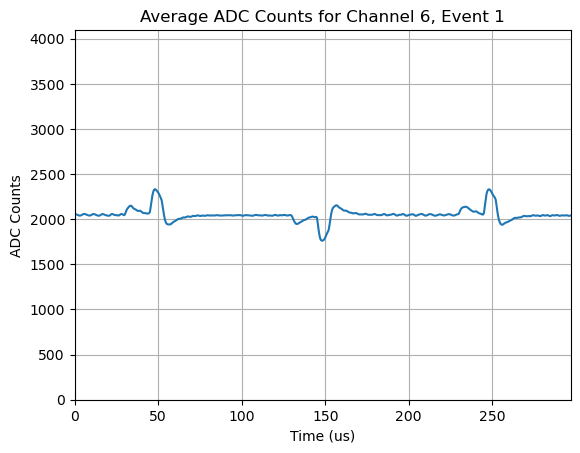

In [82]:
# set inputs, run plotter
file_list = [450, 451, 452]
active_ch = 6
event_id = 1

waveform_plotter(file_list, active_ch=6, event_id=1, overlay=1, average=1)

## ADC Calibration

In [56]:
def findpeaks(channels):
    peaks = dict()
    Q = dict()
    for ch in channels:
        # extract file_list and pulse heights for given channel
        mask_ch = csv[csv['ADC Ch.'].isin([ch])]
        file_list = mask_ch['File ID'].tolist()
        mV = mask_ch['Input (mVpp)'].tolist()
        
        # convert mV to charge
        Vdiv = (1/11) # preamp voltage divider
        Cin = 1 # preamp input capacitance, in pF
        Q[ch] = (np.array(mV) * Vdiv * 10**-3) * (Cin * 10**-12) * 10**15 # charge in fC
        
        peaks[ch] = []
        for filename in file_list:
            df = df_dict[f'{filename}']

            # find FEM for run
            fem_id = csv.loc[csv['File ID'] == filename, 'FEM ID'].iloc[0]
            
            # slice dataframe for FEM and desired channel, find max height for each event
            slice = df[(df['fem_id'] == fem_id) & (df['channel_id'] == ch)].values 
            event_ids = np.unique(slice[:, 2])
            max_counts = []
            for event in event_ids:
                mask = slice[:, 2] == event
                max_counts = np.max(np.abs(slice[mask, 3] - 2048))+2048
            peaks[ch].append(max_counts.mean())
            
    return peaks, Q

### ADC Peaks vs. Input Charge Plotter

In [57]:
def plot_peaks_vs_Q(channels, overlay=1):
    peaks, Q = findpeaks(channels)
    # if overlay is enabled, plot on the same figure
    if overlay:
        figure = plt.figure(figsize=[9,6])
        [plt.plot(Q[c], peaks[c], marker='x', linestyle='None', label=f'Ch.{c}') for c in channels]
        plt.title(f'ADC Amplitude vs. Input Charge')
        plt.xlabel('Input Charge (fC)', fontsize=20)
        plt.ylabel('Counts')
        plt.ylim(plt.ylim()[0], 4150)
        plt.grid(True)
        plt.legend(fontsize=22)
        plt.show()
    else:
        for c in active_ch:
            plt.figure(figsize=[9,6])
            plt.plot(Q[c], peaks[c], marker='x', linestyle='None', label=f'Ch.{c}')
            plt.title(f'ADC Amplitude vs. Input Charge')
            plt.xlabel('Input Charge (fC)', fontsize=20)
            plt.ylabel('Counts')
            plt.ylim(plt.ylim()[0], 4150)
            plt.grid(True)
            plt.legend(fontsize=22)
            plt.show()
            
    return figure

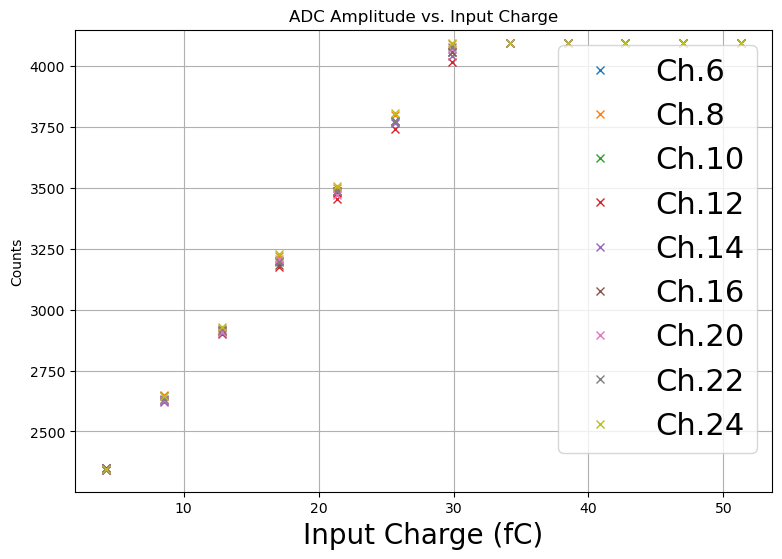

In [59]:
# set inputs and run functions
channels = [6, 8, 10, 12, 14, 16, 20, 22, 24]
my_figure = plot_peaks_vs_Q(channels, overlay=1)

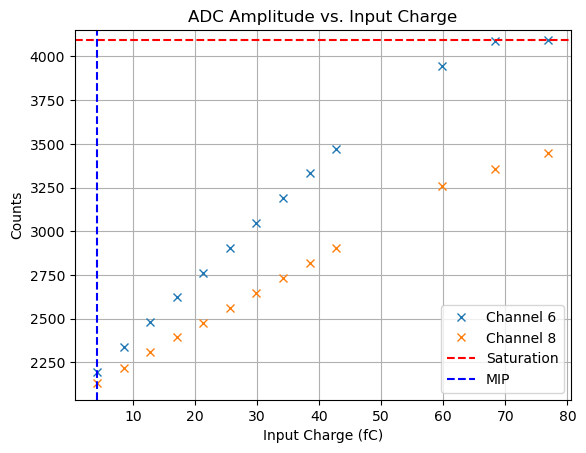

In [105]:
# add noise, saturation, and MIP bound to plot (only if they don't already exist)
if not any(line.get_label() == 'Saturation' for line in ax.get_lines()):
    ax.axhline(y=4095, color='r', linestyle='--', label='Saturation')
if not any(line.get_label() == 'MIP' for line in ax.get_lines()):
    ax.axvline(x=4.27, color='b', linestyle='--', label='MIP')
# if not any(line.get_label() == 'Noise' for line in ax.get_lines()):
#     ax.axhline(y=4095, color='r', linestyle='--', label='Noise')

ax.legend()
ampQ

### Linear Fitting

In [ ]:
# hold off on editing this

66.53829787287077 2061.1000000842514


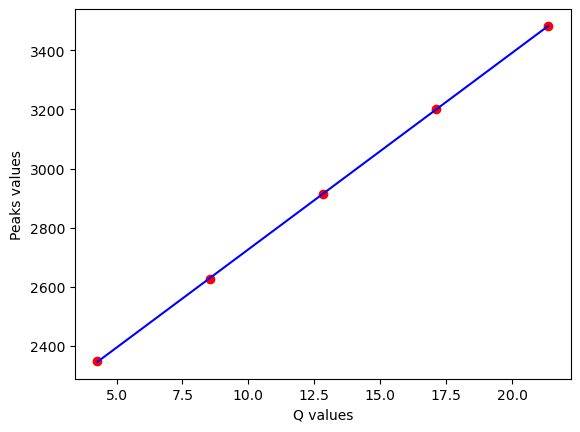

In [90]:
# def linearity(channels):
peaks, Q = findpeaks([6])

def line(params, x):
    m, b = params
    return m * x + b

def objective(params, x, y):
    return np.sum((y - line(params, x)) ** 2)
    
guess = [1.0, 2048.0]
range = 5 # only look at the first 5 data points (approximate linear region)
peaksrange = np.array(peaks[6][:range])
Qrange = np.array(Q[6][:range])

# perform the minimization
result = minimize(objective, guess, args=(Qrange, peaksrange))

# results
m, b = result.x
print(m, b)

# plot
plt.scatter(Qrange, peaksrange, color='red')
plt.plot(Qrange, line([m, b], Qrange), color='blue')
plt.xlabel('Q values')
plt.ylabel('Peaks values')
plt.show()

In [ ]:
resolution = m

Cin = 1 # preamp input capacitance, in pF
dyn_range = (resolution*4096)/

Vdiv = (1/11) # preamp voltage divider
Cin = 1 
Q[ch] = (np.array(mV) * Vdiv * 10**-3) * (Cin * 10**-12) * 10**15 # charge in fC

## Noise

In [ ]:
# noise rms plot; take baseline rms for each channel (with minimal crosstalk, i.e. when the active channel is furthest away)

## Crosstalk

In [ ]:
# plot adc amplitude vs channel number for each active channel configuration
# 3D hist of channel vs channel crosstalk